In [316]:
import string
from collections import Counter
from statistics import mean

import eli5
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.tools as tls
import shap
import tensorflow as tf
import tensorflow_addons as tfa
import torch
import torch.nn as nn
from captum.attr import IntegratedGradients, LayerConductance, NeuronConductance
from eli5.sklearn import PermutationImportance
from scipy import stats
from scipy.optimize import minimize
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from optimizer import Lookahead
from radam import RAdam

plt.style.use("seaborn-pastel")
%matplotlib inline

# initiate plotly and cufflinks for offline mode
py.offline.init_notebook_mode(connected=True)
cf.go_offline()
# initiate Javascript for SHAP
shap.initjs()

In [2]:
NUM_FEATS = 20
features, output, coef = make_regression(
    n_samples=1000,
    # three features
    n_features=NUM_FEATS,
    # where only two features are useful,
    n_informative=15,
    # a single target value per observation
    n_targets=1,
    # 0.0 standard deviation of the guassian noise
    noise=0.1,
    # show the true coefficient used to generated the data
    coef=True,
)

In [3]:
scaled_coef = (coef - coef.min()) / (coef.max() - coef.min())

In [4]:
alphabet_list = list(string.ascii_lowercase)
column_names = np.array(alphabet_list[0:NUM_FEATS])
df_features = pd.DataFrame(features, columns=column_names)

In [5]:
df_output = pd.DataFrame(output, columns=["output"])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, output, test_size=0.2, shuffle=True, random_state=42)

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [8]:
rf_regr = RandomForestRegressor(max_depth=7, n_estimators=700)
rf_regr.fit(X_train, y_train)
rf_predicted = rf_regr.predict(X_test)

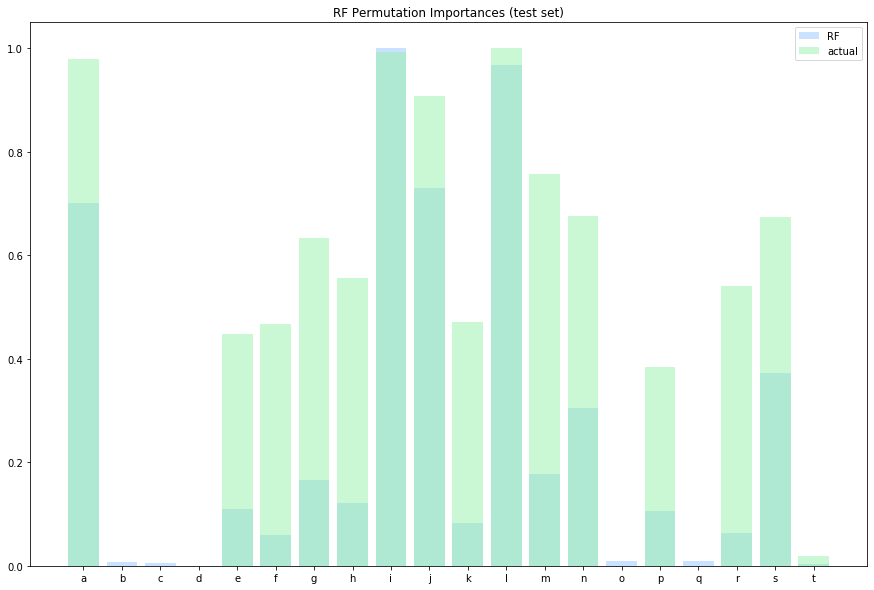

In [9]:
pi_result_rf = permutation_importance(rf_regr, X_test, y_test, n_repeats=10, random_state=42, scoring=mae_scorer)


pi_result_rf_scaled = (pi_result_rf.importances_mean - pi_result_rf.importances_mean.min()) / (
    pi_result_rf.importances_mean.max() - pi_result_rf.importances_mean.min()
)
pos = np.arange(column_names.size)
plt.figure(figsize=(15, 10))
plt.bar(pos, pi_result_rf_scaled, align="center", alpha=0.5, label="RF")
plt.bar(pos, scaled_coef, align="center", alpha=0.5, label="actual")
plt.xticks(pos, column_names)
plt.title("RF Permutation Importances (test set)")
plt.legend(loc="best")
plt.show()

In [10]:
gb_regr = GradientBoostingRegressor(max_depth=5, n_estimators=500)
gb_regr.fit(X_train, y_train)
gb_predicted = gb_regr.predict(X_test)

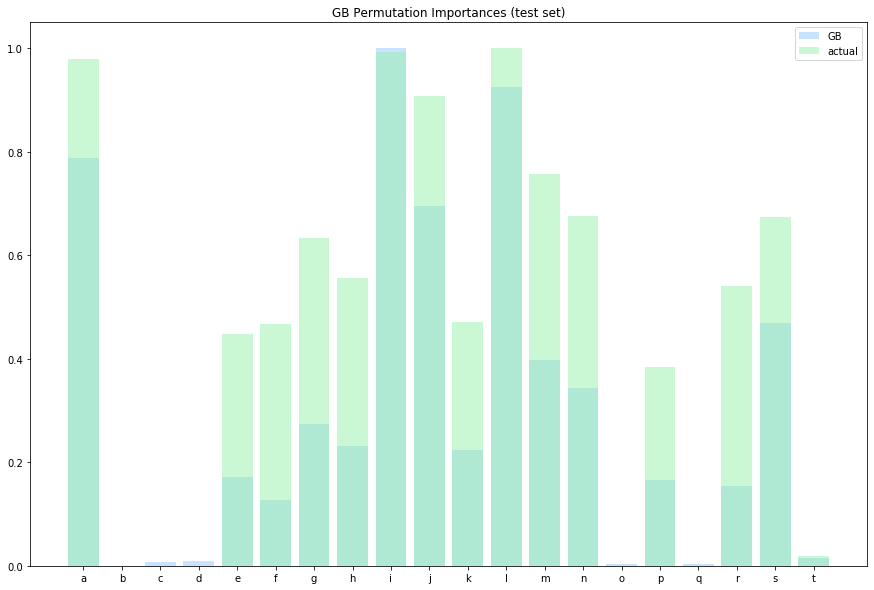

In [11]:
pi_result_gb = permutation_importance(gb_regr, X_test, y_test, n_repeats=10, random_state=42, scoring=mae_scorer)

pi_result_gb_scaled = (pi_result_gb.importances_mean - pi_result_gb.importances_mean.min()) / (
    pi_result_gb.importances_mean.max() - pi_result_gb.importances_mean.min()
)
pos = np.arange(column_names.size)
plt.figure(figsize=(15, 10))
plt.bar(pos, pi_result_gb_scaled, align="center", alpha=0.5, label="GB")
plt.bar(pos, scaled_coef, align="center", alpha=0.5, label="actual")
plt.xticks(pos, column_names)
plt.title("GB Permutation Importances (test set)")
# plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

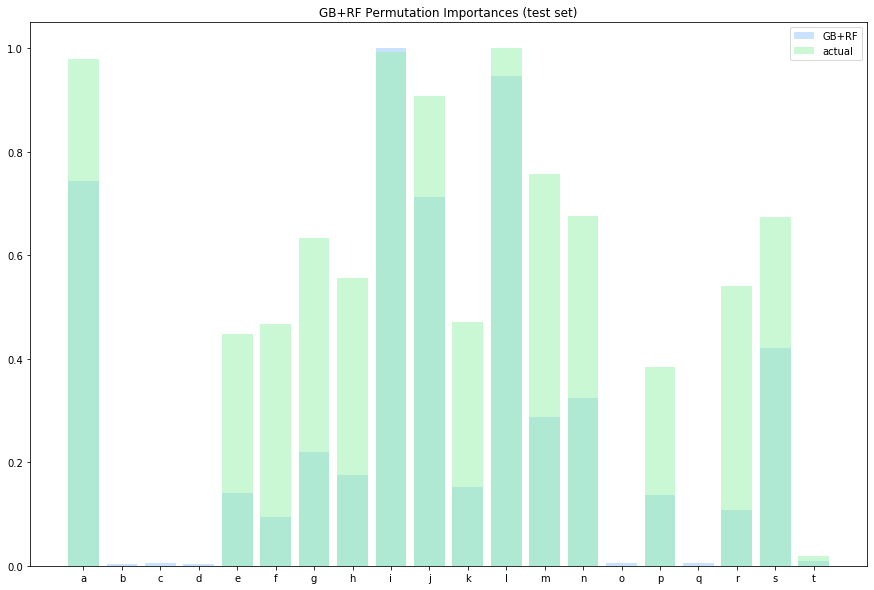

In [12]:
pos = np.arange(column_names.size)
plt.figure(figsize=(15, 10))
plt.bar(
    pos, (pi_result_gb_scaled + pi_result_rf_scaled) / 2, align="center", alpha=0.5, label="GB+RF",
)
plt.bar(pos, scaled_coef, align="center", alpha=0.5, label="actual")
plt.xticks(pos, column_names)
plt.title("GB+RF Permutation Importances (test set)")
# plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

In [13]:
print(f"GB predicted error: {np.abs(gb_predicted - y_test).mean()}")

GB predicted error: 84.72459454896925


In [14]:
print(f"RF predicted error: {np.abs(rf_predicted - y_test).mean()}")

RF predicted error: 123.11187823715285


In [15]:
print(f"RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}")
print(f"GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}")
print(f"RF+GB PI error: {np.abs(((pi_result_gb_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}")

RF PI error: 0.22912238683226943
GB PI error: 0.17776807054016014
RF+GB PI error: 0.20344522868621487


In [16]:
explainer_rf = shap.TreeExplainer(rf_regr)
shap_values_rf = explainer_rf.shap_values(df_features)

explainer_gb = shap.TreeExplainer(gb_regr)
shap_values_gb = explainer_gb.shap_values(df_features)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [17]:
gb_sv = np.abs(shap_values_gb).mean(0)
gb_sv_min = np.abs(shap_values_gb).mean(0).min()
gb_sv_max = np.abs(shap_values_gb).mean(0).max()

gb_sv_scaled = (gb_sv - gb_sv_min) / (gb_sv_max - gb_sv_min)


rf_sv = np.abs(shap_values_rf).mean(0)
rf_sv_min = np.abs(shap_values_rf).mean(0).min()
rf_sv_max = np.abs(shap_values_rf).mean(0).max()

rf_sv_scaled = (rf_sv - rf_sv_min) / (rf_sv_max - rf_sv_min)

In [18]:
print(f"RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}")
print(f"GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}")
print(f"RF+GB SV error: {np.abs(((gb_sv_scaled+rf_sv_scaled)/2) - scaled_coef).mean()}")
print("")
print(f"GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}")
print(f"GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}")
print(f"GB PI + GB SV error: {np.abs(((gb_sv_scaled+pi_result_gb_scaled)/2) - scaled_coef).mean()}")
print("")
print(f"RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}")
print(f"RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}")
print(f"RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}")
print("")
total_pi_sv_scaled = (rf_sv_scaled + pi_result_rf_scaled + gb_sv_scaled + pi_result_gb_scaled) / 4
print(f"(RF PI + RF SV) + (GB PI + GB SV) error: {np.abs(total_pi_sv_scaled - scaled_coef).mean()}")

RF SV error: 0.23634253256535015
GB SV error: 0.13226189825829213
RF+GB SV error: 0.18430221541182115

GB PI error: 0.17776807054016014
GB SV error: 0.13226189825829213
GB PI + GB SV error: 0.15501498439922617

RF PI error: 0.22912238683226943
RF SV error: 0.23634253256535015
RF PI + RF SV error: 0.2327324596988098

(RF PI + RF SV) + (GB PI + GB SV) error: 0.19387372204901795


# DNN

In [19]:
y_test.shape

(200,)

In [20]:
class SimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        #         self.linear1 = nn.Linear(20, 128)
        #         self.relu1 = nn.ReLU()

        #         self.linear2 = nn.Linear(128, 256)
        #         self.relu2 = nn.ReLU()

        #         self.linear3 = nn.Linear(256, 128)
        #         self.relu3 = nn.ReLU()

        #         self.linear4 = nn.Linear(128, 64)
        #         self.relu4 = nn.ReLU()

        self.linear5 = nn.Linear(NUM_FEATS, 64)
        self.relu5 = nn.Tanh()

        self.linear6 = nn.Linear(64, 32)
        self.relu6 = nn.Tanh()

        self.linear7 = nn.Linear(32, 16)
        self.relu7 = nn.Tanh()

        self.linear8 = nn.Linear(16, 8)
        self.relu8 = nn.Tanh()

        self.linear9 = nn.Linear(8, 6)
        self.relu9 = nn.Tanh()

        self.linear10 = nn.Linear(6, 4)
        self.relu10 = nn.Tanh()

        self.linear11 = nn.Linear(4, 1)
        # self.relu11 = nn.ReLU()

    def forward(self, x):
        #         x = self.relu1(self.linear1(x))
        #         x = self.relu2(self.linear2(x))
        #         x = self.relu3(self.linear3(x))
        #         x = self.relu4(self.linear4(x))
        x = self.relu5(self.linear5(x))
        x = self.relu6(self.linear6(x))
        x = self.relu7(self.linear7(x))
        x = self.relu8(self.linear8(x))
        x = self.relu9(self.linear9(x))
        x = self.relu10(self.linear10(x))
        x = self.linear11(x)
        return x


from optimizer import Lookahead
from radam import RAdam

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))
net = SimpleNNModel()


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


net.apply(init_weights)

USE_PRETRAINED_MODEL = False
n_batches = 32
if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load("interpret_model.pt"))
    print("Model Loaded!")
else:
    criterion = nn.MSELoss()
    num_epochs = 1000

    # optimizer = torch.optim.AdamW(net.parameters(), lr=0.0003, weight_decay=0.01)
    base_optim = RAdam(net.parameters(), lr=0.01)
    optimizer = Lookahead(base_optim, k=6, alpha=0.5)
    input_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(y_train).type(torch.FloatTensor)
    for epoch in range(num_epochs):
        for i in range(n_batches):
            local_X, local_y = (
                input_tensor[i * n_batches : (i + 1) * n_batches,],
                label_tensor[i * n_batches : (i + 1) * n_batches,],
            )
            output = net(input_tensor)
            loss = criterion(output, label_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print("Epoch {}/{} => Loss: {:.6f}".format(epoch + 1, num_epochs, loss.item()))

    torch.save(net.state_dict(), "interpret_model.pt")

Epoch 1/1000 => Loss: 49183.531250
Epoch 101/1000 => Loss: 36337.789062
Epoch 201/1000 => Loss: 25745.580078
Epoch 301/1000 => Loss: 21142.714844
Epoch 401/1000 => Loss: 9962.058594
Epoch 501/1000 => Loss: 5799.657715
Epoch 601/1000 => Loss: 3446.298340
Epoch 701/1000 => Loss: 1862.509888
Epoch 801/1000 => Loss: 1111.798096
Epoch 901/1000 => Loss: 612.406616


In [21]:
test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)
test_output = net(test_input_tensor).detach().numpy()
print("Test MSE:", np.sqrt((np.abs(test_output - y_test)).mean()))

Test MSE: 7.924670988815741


In [22]:
ig = IntegratedGradients(net)
test_input_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, return_convergence_delta=True)
attr = attr.detach().numpy()

feature_names = list(column_names)

Intergrated Gradient Average Feature Importances
a :  -31.926
b :  24.844
c :  8.992
d :  22.202
e :  -30.390
f :  2.003
g :  -8.456
h :  -18.461
i :  -42.638
j :  -11.384
k :  -8.481
l :  28.732
m :  -14.263
n :  1.046
o :  2.048
p :  3.783
q :  -0.635
r :  11.648
s :  21.337
t :  -10.012


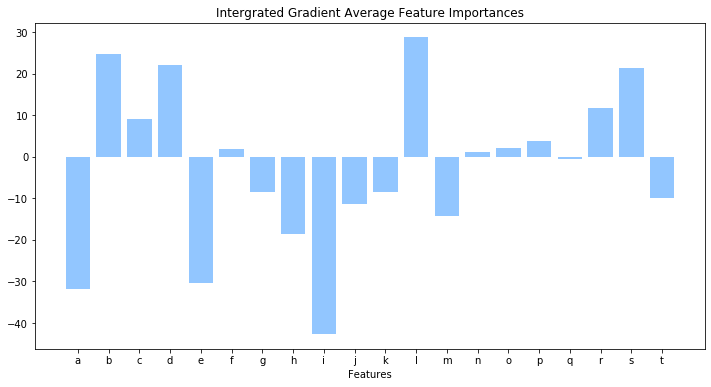

In [23]:
def visualize_importances(
    feature_names,
    importances,
    title="Intergrated Gradient Average Feature Importances",
    plot=True,
    axis_title="Features",
):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", "%.3f" % (importances[i]))
    x_pos = np.arange(len(feature_names))
    if plot:
        plt.figure(figsize=(12, 6))
        plt.bar(x_pos, importances, align="center")
        plt.xticks(x_pos, feature_names, wrap=False)
        plt.xlabel(axis_title)
        plt.title(title)


visualize_importances(column_names, np.mean(attr, axis=0))

In [24]:
dnn_ig = np.abs(np.mean(attr, axis=0))
dnn_ig = np.abs(dnn_ig)
dnn_ig_min = np.abs(dnn_ig).min()
dnn_ig_max = np.abs(dnn_ig).max()

dnn_ig_scaled = (dnn_ig - dnn_ig_min) / (dnn_ig_max - dnn_ig_min)
dnn_ig_scaled

array([0.7449648 , 0.5763665 , 0.1989556 , 0.51347524, 0.7083969 ,
       0.03257189, 0.18621594, 0.42439672, 1.        , 0.25591016,
       0.1868    , 0.6689349 , 0.32446525, 0.00979534, 0.03364253,
       0.07495166, 0.        , 0.2621914 , 0.49286383, 0.22324702],
      dtype=float32)

In [25]:
print(f"DNN IG error: {np.abs(dnn_ig_scaled - scaled_coef).mean()}")
# print(f'RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}')
# print(f'RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}')

DNN IG error: 0.308448732165869


In [26]:
def base_model():
    model = tf.keras.Sequential(
        [
            layers.Dense(
                64, activation="tanh", input_shape=(X_train.shape[1],), bias_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            layers.Dense(64, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(32, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(16, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(8, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(6, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(4, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dense(1, activation="linear"),
        ]
    )

    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    # tf.keras.optimizers.Adam(1e-4)
    # Configure a model for mean-squared error regression.
    model.compile(optimizer=ranger, loss="mse", metrics=["mae"])  # mean squared error  # mean absolute error

    return model


# reshape for deep model
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=100, verbose=0, mode="auto", baseline=None, restore_best_weights=True,
)

dnn_model = KerasRegressor(
    build_fn=base_model, epochs=1000, batch_size=32, verbose=0, validation_split=0.1, callbacks=[callback],
)

history = dnn_model.fit(X_train, y_train)
perm = PermutationImportance(dnn_model, scoring=mae_scorer, random_state=1).fit(X_train, y_train)
dnn_pi_df = eli5.explain_weights_df(perm, feature_names=column_names.tolist())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
dnn_pi_df.sort_values(by=["feature"], inplace=True)
dnn_pi = dnn_pi_df["weight"].values
dnn_pi_scaled = (dnn_pi - dnn_pi.min()) / (dnn_pi.max() - dnn_pi.min())
print(f"DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}")

DNN PI error: 0.09068426812386193


In [28]:
model = tf.keras.Sequential(
    [
        layers.Dense(
            64, activation="tanh", input_shape=(X_train.shape[1],), bias_regularizer=tf.keras.regularizers.l2(0.01),
        ),
        layers.Dense(64, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(32, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(16, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(8, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(6, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(4, activation="tanh", bias_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(1, activation="linear"),
    ]
)

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
# tf.keras.optimizers.Adam(1e-4)
# Configure a model for mean-squared error regression.
model.compile(optimizer=ranger, loss="mse", metrics=["mae"])  # mean squared error  # mean absolute error


# reshape for deep model
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=100, verbose=0, mode="auto", baseline=None, restore_best_weights=True,
)


model.fit(
    X_train, y_train, epochs=1000, batch_size=32, verbose=0, validation_split=0.1, callbacks=[callback],
)

In [29]:
tf.keras.models.save_model(model, "dnn_model.h5")  # creates a HDF5 file 'my_model.h5'

# model = tf.keras.models.load_model('dnn_model.h5')

In [30]:
explainer_dnn = shap.KernelExplainer(model.predict, data=df_features.iloc[:300, :])
shap_values = explainer_dnn.shap_values(df_features.iloc[:300, :], nsamples=200, l1_reg=f"num_features({NUM_FEATS})")

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [31]:
dnn_sv = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0)
dnn_sv_min = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0).min()
dnn_sv_max = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0).max()

dnn_sv_scaled = (dnn_sv - dnn_sv_min) / (dnn_sv_max - dnn_sv_min)
print(f"DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}")

DNN SV error: 0.051108944501594054


In [32]:
rf_sv_scaled_reshaped = np.reshape(rf_sv_scaled, (rf_sv_scaled.shape[0], 1))
pi_result_rf_scaled_reshaped = np.reshape(pi_result_rf_scaled, (pi_result_rf_scaled.shape[0], 1))
gb_sv_scaled_reshaped = np.reshape(gb_sv_scaled, (gb_sv_scaled.shape[0], 1))
pi_result_gb_scaled_reshaped = np.reshape(pi_result_gb_scaled, (pi_result_gb_scaled.shape[0], 1))
dnn_pi_scaled_reshaped = np.reshape(dnn_pi_scaled, (dnn_pi_scaled.shape[0], 1))
dnn_sv_scaled_reshaped = np.reshape(dnn_sv_scaled, (dnn_sv_scaled.shape[0], 1))
dnn_ig_scaled_reshaped = np.reshape(dnn_ig_scaled, (dnn_ig_scaled.shape[0], 1))

all_stacked = np.hstack(
    (
        rf_sv_scaled_reshaped,
        pi_result_rf_scaled_reshaped,
        gb_sv_scaled_reshaped,
        pi_result_gb_scaled_reshaped,
        dnn_pi_scaled_reshaped,
        dnn_sv_scaled_reshaped,
        dnn_ig_scaled_reshaped,
    )
)


all_stacked_df = pd.DataFrame(all_stacked, columns=["rf_sv", "rf_pi", "gb_sv", "gb_pi", "dnn_pi", "dnn_sv", "dnn_ig"])

all_stacked_df.to_csv("all_stacked.csv")

In [33]:
print(f"RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}")
print(f"GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}")
print(f"DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}")
print(f"RF+GB+DNN PI error: {np.abs(((pi_result_gb_scaled+pi_result_rf_scaled+dnn_pi_scaled)/3) - scaled_coef).mean()}")
print("")
print(f"RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}")
print(f"GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}")
print(f"DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}")
print(f"RF+GB+DNN SV error: {np.abs(((rf_sv_scaled+gb_sv_scaled+dnn_sv_scaled)/3) - scaled_coef).mean()}")
print("")
print(f"GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}")
print(f"GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}")
print(f"GB PI + GB SV error: {np.abs(((gb_sv_scaled+pi_result_gb_scaled)/2) - scaled_coef).mean()}")
print("")
print(f"RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}")
print(f"RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}")
print(f"RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}")
print("")
print(f"DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}")
print(f"DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}")
print(f"DNN IG error: {np.abs(dnn_ig_scaled - scaled_coef).mean()}")
print(f"DNN PI + DNN SV + DNN IG error: {np.abs(((dnn_pi_scaled+dnn_sv_scaled+dnn_ig_scaled)/3) - scaled_coef).mean()}")
print("")

point_five = np.full((NUM_FEATS), 0.5)
zeros = np.full((NUM_FEATS), 0)
ones = np.full((NUM_FEATS), 1)
print(f"Dummy Average of 0.0 error: {np.abs(zeros - scaled_coef).mean()}")
print(f"Dummy Average of 0.5 error: {np.abs(point_five - scaled_coef).mean()}")
print(f"Dummy Average of 0.1 error: {np.abs(ones - scaled_coef).mean()}")
print("")

RF PI error: 0.22912238683226943
GB PI error: 0.17776807054016014
DNN PI error: 0.09068426812386193
RF+GB+DNN PI error: 0.16538774890593028

RF SV error: 0.23634253256535015
GB SV error: 0.13226189825829213
DNN SV error: 0.051108944501594054
RF+GB+DNN SV error: 0.13943396551557857

GB PI error: 0.17776807054016014
GB SV error: 0.13226189825829213
GB PI + GB SV error: 0.15501498439922617

RF PI error: 0.22912238683226943
RF SV error: 0.23634253256535015
RF PI + RF SV error: 0.2327324596988098

DNN PI error: 0.09068426812386193
DNN SV error: 0.051108944501594054
DNN IG error: 0.308448732165869
DNN PI + DNN SV + DNN IG error: 0.14113459589291516

Dummy Average of 0.0 error: 0.47494618830764745
Dummy Average of 0.5 error: 0.2961939971098212
Dummy Average of 0.1 error: 0.5250538116923525



## Median

In [34]:
total_scaled_median = np.median(all_stacked, axis=1)

## Mean

In [35]:
total_scaled_mean = (
    rf_sv_scaled
    + pi_result_rf_scaled
    + gb_sv_scaled
    + pi_result_gb_scaled
    + dnn_pi_scaled
    + dnn_sv_scaled
    + dnn_ig_scaled
) / 7

## Box-whiskers (Average after removing outliers)

In [36]:
total_scaled_box_whiskers = np.array([])
for i in range(all_stacked.shape[0]):
    temp_whiskers = np.array([])
    q3 = np.quantile(all_stacked[i, :], 0.75)
    q1 = np.quantile(all_stacked[i, :], 0.25)
    upper_whiskers = q3 + (1.5 * (q3 - q1))
    lower_whiskers = q1 - (1.5 * (q3 - q1))
    for j in range(all_stacked[i, :].shape[0]):
        if (all_stacked[i, :][j] >= lower_whiskers) and (all_stacked[i, :][j] <= upper_whiskers):
            temp_whiskers = np.append(temp_whiskers, all_stacked[i, :][j])
    total_scaled_box_whiskers = np.append(total_scaled_box_whiskers, temp_whiskers.mean())

##  Modified Thompson Tau test (average after removing outliers)

In [37]:
# (1) calculate sample mean
# (2) calculate delta_min = |mean - min| and delta_max|mean - max|
# (3) tau value from tau table value for sample size 7: 1.7110
# (4) calculate standard deviation
# (5) multiply tau with standard deviation = tau*std threshold
# (6) compare (3) and (5)
tau = 1.7110


def tau_test(test_data):
    for i in range(test_data.shape[0]):
        test_data_mean = test_data.mean()
        test_data_std = np.std(test_data, ddof=1)
        test_data_min = test_data.min()
        test_data_min_index = np.argmin(test_data)
        test_data_max = test_data.max()
        test_data_max_index = np.argmax(test_data)
        test_data_min_delta = np.abs(test_data_min - test_data_mean)
        test_data_max_delta = np.abs(test_data_max - test_data_mean)

        if test_data_min_delta >= test_data_max_delta:
            if test_data_min_delta > tau * test_data_std:
                test_data = np.delete(test_data, test_data_min_index)
        else:
            if test_data_max_delta > tau * test_data_std:
                test_data = np.delete(test_data, test_data_max_index)
    return test_data


total_scaled_tau_test = np.array([])
for i in range(all_stacked.shape[0]):
    mean_tau = np.array([tau_test(all_stacked[i, :]).mean()])
    total_scaled_tau_test = np.append(total_scaled_tau_test, mean_tau)

total_scaled_tau_test = np.array([total_scaled_tau_test])
total_scaled_tau_test = np.reshape(total_scaled_tau_test, (-1,))

## Mode

In [38]:
total_scaled_mode = np.array([])
for i in range(all_stacked.shape[0]):
    params = stats.norm.fit(all_stacked[i, :])

    def your_density(x):
        return -stats.norm.pdf(x, *params)

    total_scaled_mode = np.append(total_scaled_mode, minimize(your_density, 0).x[0])

total_scaled_mode = np.reshape(total_scaled_mode, (-1,))

## Helper function to calculate Kendall-Tau Rank and Spearman Rank

In [41]:
def helper_rank(rank_function, data, methods_columns_name):

    # calculate rank correlation and p-value. null hypothesis is that two sets of data are uncorrelated
    all_corr = np.zeros((data.shape[1], data.shape[1]))
    all_p_value = np.zeros((data.shape[1], data.shape[1]))
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            corr, p_value = rank_function(data[:, i], data[:, j])
            all_corr[i, j] = corr
            all_p_value[i, j] = p_value

    # store correlation and p-value in dataframe
    df_corr = pd.DataFrame(all_corr, columns=methods_columns_name, index=methods_columns_name)
    df_p_value = pd.DataFrame(all_p_value, columns=methods_columns_name, index=methods_columns_name)

    # generate truth table for p-value. If p value < 0.05(significant) value is True/1.0
    df_p_value_significance = df_p_value < 0.05

    # remove diagonal significance as it is measured against itself
    for i in range(df_p_value.shape[0]):
        df_p_value_significance.iloc[i, i] = None

    # decide if feature importance method should be kept
    # if majority are correlated and statistically significant then method are kept
    keep_FI_method = []
    keep_or_not = True

    # zeros placeholder same number of rows/feature
    all_stacked_corr = np.zeros((data.shape[0], 1))

    # loop to include only majority voted method. Majority voted in this case is equivalent
    # to all method deemed correlated by statistical significance
    for i in range(df_p_value_significance.shape[1]):
        keep_or_not = Counter(df_p_value_significance.iloc[:, i]).most_common()[0][0]
        keep_FI_method.append(keep_or_not)
        if keep_or_not:
            all_stacked_corr = np.hstack((all_stacked_corr, np.reshape(data[:, i], (-1, 1))))

    # remove the zeros placeholder for shape
    all_stacked_corr = all_stacked_corr[:, 1:]

    # calculate mean for each feature
    total_scaled_corr = np.mean(all_stacked_corr, axis=1)
    return total_scaled_corr

## Kendall Tau Rank

In [42]:
columns_name = ["rf_sv", "rf_pi", "gb_sv", "gb_pi", "dnn_pi", "dnn_sv", "dnn_ig"]
total_scaled_kendall_tau = helper_rank(stats.kendalltau, all_stacked, columns_name)

## Pearson Rank

In [43]:
total_scaled_spearman = helper_rank(stats.spearmanr, all_stacked, columns_name)

## Majority Voting

In [44]:
# obtain rank of each feature for each feature importance
all_stacked_rank = np.zeros((20, 1))
for i in range(all_stacked.shape[1]):
    all_stacked_rank = np.hstack((all_stacked_rank, np.reshape(np.argsort(all_stacked[:, i]), (-1, 1))))

all_stacked_rank = all_stacked_rank[:, 1:]

In [45]:
# select the most common rank for each feature
most_common_rank = []
for i in range(all_stacked_rank.shape[0]):

    majority_number = Counter(all_stacked_rank[i, :]).most_common()[0][1]
    second_majority_number = Counter(all_stacked_rank[i, :]).most_common()[1][1]
    # record instances if there are two majority, else just append the majority
    if (majority_number) == (second_majority_number):
        most_common_rank.append(
            [
                int(Counter(all_stacked_rank[i, :]).most_common()[0][0]),
                int(Counter(all_stacked_rank[i, :]).most_common()[1][0]),
            ]
        )
    else:
        most_common_rank.append(([int(Counter(all_stacked_rank[i, :]).most_common()[0][0])]))

In [46]:
# average of majorty
total_scaled_majority_vote = list()
for i in range(all_stacked_rank.shape[0]):
    temp_majority_avg = []
    for j in range(all_stacked_rank.shape[1]):
        # single majority
        if len(most_common_rank[i]) == 1:
            if all_stacked_rank[i, j] == most_common_rank[i][0]:
                temp_majority_avg.append(all_stacked[i, j])
        # double majority
        else:
            if (all_stacked_rank[i, j] == most_common_rank[i][0]) or (all_stacked_rank[i, j] == most_common_rank[i][1]):
                temp_majority_avg.append(all_stacked[i, j])
    total_scaled_majority_vote.append(mean(temp_majority_avg))

total_scaled_majority_vote = np.array(total_scaled_majority_vote)

## Renormalise the result

In [47]:
# renormalise the result
def normalise(array):
    return (array - array.min()) / (array.max() - array.min())


total_scaled_median = normalise(total_scaled_median)
total_scaled_mean = normalise(total_scaled_mean)
total_scaled_mode = normalise(total_scaled_mode)
total_scaled_box_whiskers = normalise(total_scaled_box_whiskers)
total_scaled_tau_test = normalise(total_scaled_tau_test)
total_scaled_majority_vote = normalise(total_scaled_majority_vote)
total_scaled_kendall_tau = normalise(total_scaled_kendall_tau)
total_scaled_spearman = normalise(total_scaled_spearman)

In [48]:
# test shape
assert total_scaled_median.shape == (
    NUM_FEATS,
), f"Shape mismatch: Expect shape to be ({NUM_FEATS},) but receive {(total_scaled_median.shape)}"
assert total_scaled_mean.shape == (
    NUM_FEATS,
), f"Shape mismatch: Expect shape to be ({NUM_FEATS},) but receive {(total_scaled_mean.shape)}"
assert total_scaled_mode.shape == (
    NUM_FEATS,
), f"Shape mismatch: Expect shape to be ({NUM_FEATS},) but receive {(total_scaled_mode.shape)}"
assert total_scaled_box_whiskers.shape == (
    NUM_FEATS,
), f"Shape mismatch: Expect shape to be ({NUM_FEATS},) but receive {(total_scaled_box_whiskers.shape)}"
assert total_scaled_tau_test.shape == (
    NUM_FEATS,
), f"Shape mismatch: Expect shape to be ({NUM_FEATS},) but receive {(total_scaled_tau_test.shape)}"
assert total_scaled_majority_vote.shape == (
    NUM_FEATS,
), f"Shape mismatch: Expect shape to be ({NUM_FEATS},) but receive {(total_scaled_majority_vote.shape)}"
assert total_scaled_kendall_tau.shape == (
    NUM_FEATS,
), f"Shape mismatch: Expect shape to be ({NUM_FEATS},) but receive {(total_scaled_kendall_tau.shape)}"
assert total_scaled_spearman.shape == (
    NUM_FEATS,
), f"Shape mismatch: Expect shape to be ({NUM_FEATS},) but receive {(total_scaled_spearman.shape)}"

## Print all final result

In [49]:
print(f" All averaged error (mean): {np.abs(total_scaled_mean - scaled_coef).mean()}")
print(f" All averaged error (median): {np.abs(total_scaled_median - scaled_coef).mean()}")
print(f" All averaged error (mode): {np.abs(total_scaled_mode - scaled_coef).mean()}")
print(f" All averaged error (box-whiskers): {np.abs(total_scaled_box_whiskers - scaled_coef).mean()}")
print(f" All averaged error (tau-test): {np.abs(total_scaled_tau_test - scaled_coef).mean()}")
print(f" All averaged error (majority vote): {np.abs(total_scaled_majority_vote - scaled_coef).mean()}")
print(f" All averaged error (Kendall tau): {np.abs(total_scaled_kendall_tau - scaled_coef).mean()}")
print(f" All averaged error (Spearman Rho): {np.abs(total_scaled_spearman - scaled_coef).mean()}")

 All averaged error (mean): 0.15953283215430616
 All averaged error (median): 0.1594950772238029
 All averaged error (mode): 0.2362008227540681
 All averaged error (box-whiskers): 0.15471656643436546
 All averaged error (tau-test): 0.15327458110441639
 All averaged error (majority vote): 0.17159049324985717
 All averaged error (Kendall tau): 0.13952942790736117
 All averaged error (Spearman Rho): 0.13952942790736117


## Plotting the result in scatter plot

In [171]:
# save result in csv
methods = np.array(
    ["Mode", "Median", "Mean", "Box-Whiskers", "Tau Test", "Majority Vote", "Kendall Tau", "Spearman Rho", "Actual"]
)
multiplied_importance = np.append(
    [total_scaled_mode],
    [
        total_scaled_median,
        total_scaled_mean,
        total_scaled_box_whiskers,
        total_scaled_tau_test,
        total_scaled_majority_vote,
        total_scaled_kendall_tau,
        total_scaled_spearman,
        scaled_coef,
    ],
)
multiplied_feature = np.tile(feature_names, int(importance.shape[0] / len(feature_names)))
multiplied_methods = np.repeat(methods, int(importance.shape[0] / methods.shape[0]))  # for 9 different ensemble method


df_results = pd.DataFrame(
    {"Importance": multiplied_importance, "Features": multiplied_feature, "Methods": multiplied_methods}
)


df_results.to_csv("results.csv")

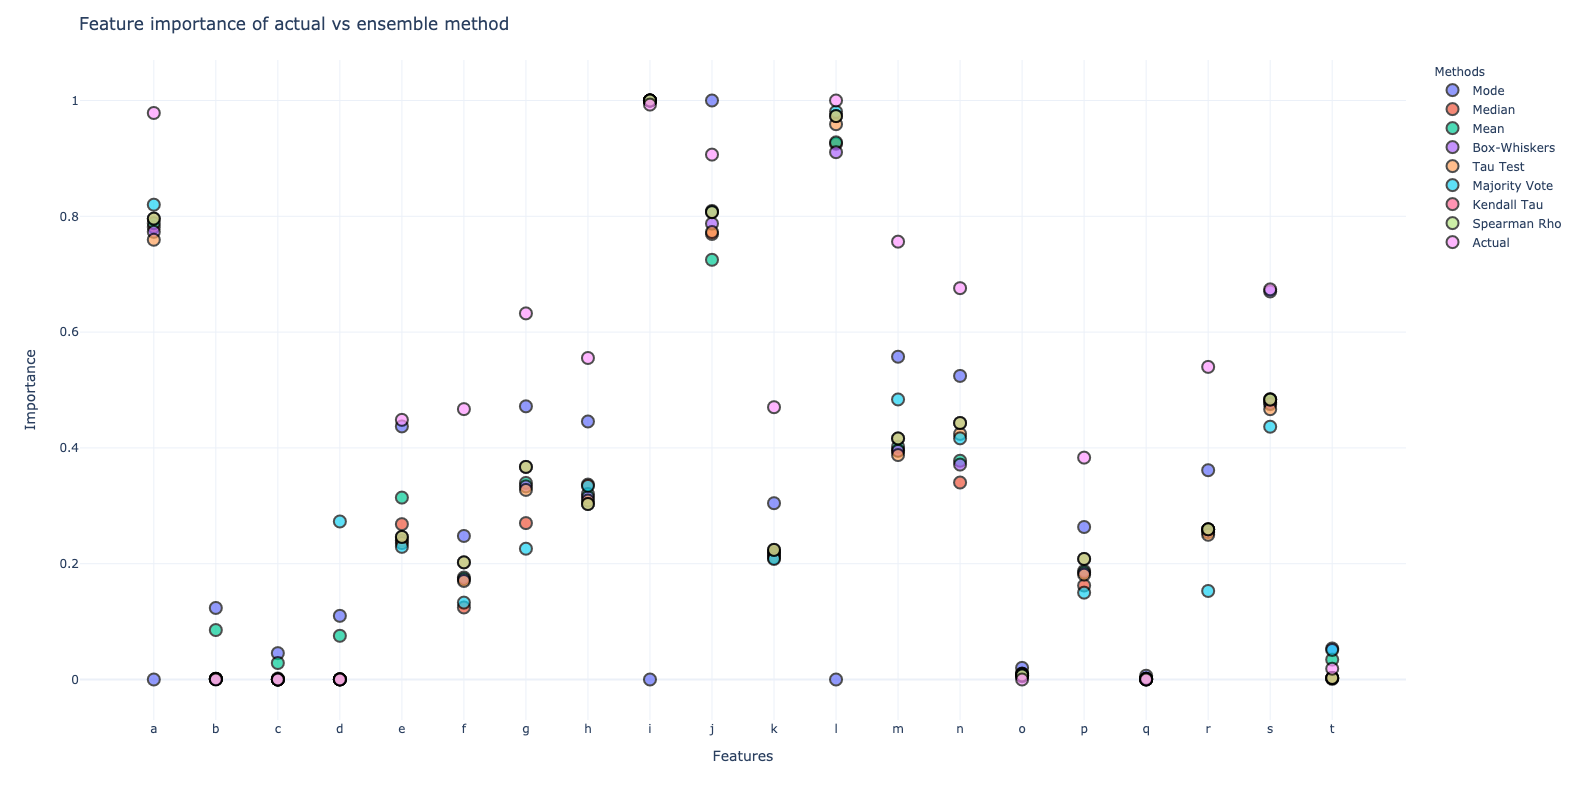

In [219]:
fig = px.scatter(df_results, x="Features", y="Importance", color="Methods")

fig.update_layout(
    template="plotly_white", title="Feature importance of actual vs ensemble method", width=1500, height=800,
)

fig.update_traces(marker=dict(size=12, line=dict(width=2, color="Black")), selector=dict(mode="markers"), opacity=0.7)

fig.write_html("results.html")
fig.show()

In [290]:
df_results_pareto = df_results.sort_values(by=["Methods", "Importance"], ascending=False)

In [291]:
df_results_pareto["sum"] = df_results_pareto.groupby(["Methods"])["Importance"].transform("sum")
df_results_pareto["cumsum"] = df_results_pareto.groupby(["Methods"])["Importance"].cumsum() / df_results_pareto["sum"]

In [292]:
df_results_pareto_cumsum = df_results_pareto.sort_values(by=["Methods", "cumsum"])

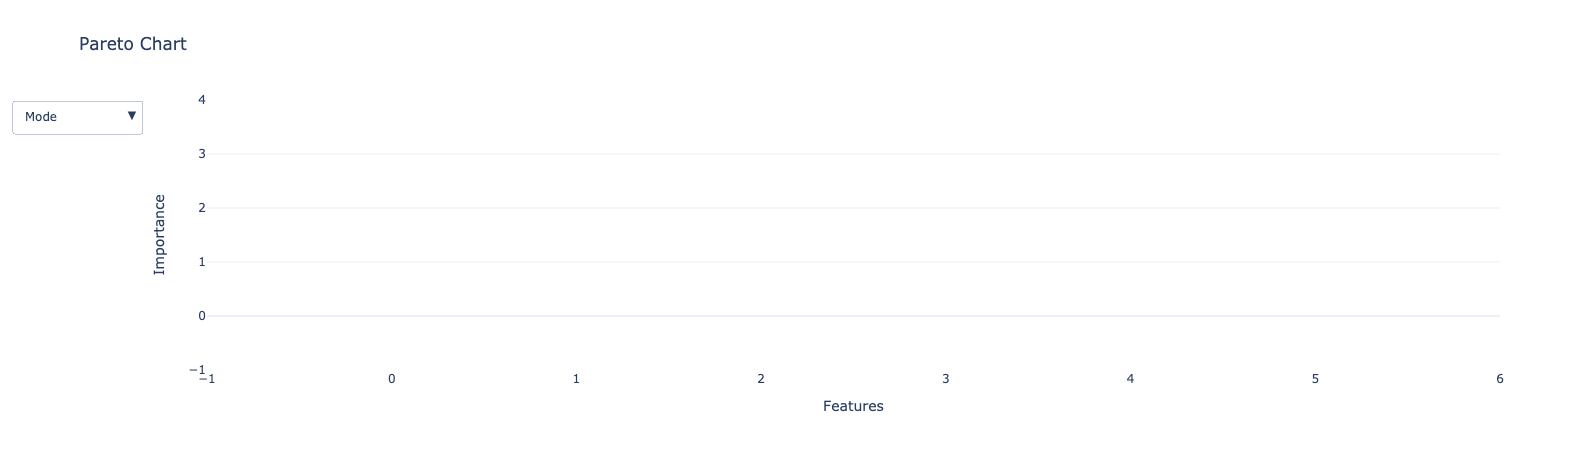

In [386]:
fig = go.Figure()
methods = np.array(
    ["Mode", "Median", "Mean", "Box-Whiskers", "Tau Test", "Majority Vote", "Kendall Tau", "Spearman Rho", "Actual"]
)
for meth in methods:
    fig.add_trace(
        go.Scatter(
            x=list(df_results_pareto_cumsum[df_results_pareto_cumsum["Methods"] == meth]["Features"]),
            y=list(df_results_pareto_cumsum[df_results_pareto_cumsum["Methods"] == meth]["cumsum"]),
            name=f'Cumulative %: {meth}',
            visible=False,
        )
    )
    
for meth in methods:
    fig.add_trace(
        go.Bar(
            x=list(df_results_pareto[df_results_pareto["Methods"] == meth]["Features"]),
            y=list(df_results_pareto[df_results_pareto["Methods"] == meth]["Importance"]),
            name=f'Bar: {meth}',
            visible=False,
        )
    )
# ["Mode", "Median", "Mean", "Box-Whiskers", "Tau Test", "Majority Vote", "Kendall Tau", "Spearman Rho", "Actual"]
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            active=0,
            buttons=[
                dict(
                    label="Mode",
                    method="update",
                    args=[
                        {"visible": [True, False, False, False, False, False, False, False, False,
                                     True, False, False, False, False, False, False, False, False]},
                        {"title": "Pareto Chart: Mode", "showlegend": True},
                    ],
                ),
                dict(
                    label="Median",
                    method="update",
                    args=[
                        {"visible": [False, True, False, False, False, False, False, False, False,
                                     False, True, False, False, False, False, False, False, False]},
                        {"title": "Pareto Chart: Median", "showlegend": True},
                    ],
                ),
                dict(
                    label="Mean",
                    method="update",
                    args=[
                        {"visible": [False, False, True, False, False, False, False, False, False,
                                     False, False, True, False, False, False, False, False, False]},
                        {"title": "Pareto Chart: Mean", "showlegend": True},
                    ],
                ),
                dict(
                    label="Box-Whiskers",
                    method="update",
                    args=[
                        {"visible": [False, False, False, True, False, False, False, False, False,
                                     False, False, False, True, False, False, False, False, False]},
                        {"title": "Pareto Chart: Box-Whiskers", "showlegend": True},
                    ],
                ),
                dict(
                    label="Tau Test",
                    method="update",
                    args=[
                        {"visible": [False, False, False, False, True, False, False, False, False,
                                     False, False, False, False, True, False, False, False, False]},
                        {"title": "Pareto Chart: Tau Test", "showlegend": True},
                    ],
                ),
                dict(
                    label="Majority Vote",
                    method="update",
                    args=[
                        {"visible": [False, False, False, False, False, True, False, False, False,
                                     False, False, False, False, False, True, False, False, False]},
                        {"title": "Pareto Chart: Majority Vote", "showlegend": True},
                    ],
                ),
                dict(
                    label="Kendall Tau",
                    method="update",
                    args=[
                        {"visible": [False, False, False, False, False, False, True, False, False,
                                     False, False, False, False, False, False, True, False, False]},
                        {"title": "Pareto Chart: Kendall Tau", "showlegend": True},
                    ],
                ),
                dict(
                    label="Spearman Rho",
                    method="update",
                    args=[
                        {"visible": [False, False, False, False, False, False, False, True, False,
                                     False, False, False, False, False, False, False, True, False]},
                        {"title": "Pareto Chart: Spearman Rho", "showlegend": True},
                    ],
                ),
                dict(
                    label="Actual",
                    method="update",
                    args=[
                        {"visible": [False, False, False, False, False, False, False, False, True,
                                     False, False, False, False, False, False, False, False, True]},
                        {"title": "Pareto Chart: Actual", "showlegend": True},
                    ],
                ),
            ],
        )
    ]
)

fig.update_layout(
    title="Pareto Chart", template="plotly_white",xaxis_title="Features", yaxis_title="Importance",
)

fig.show()

In [172]:
# Peirce's criterion <- important because its robust statistics
# fuzzy mean
# dbscan
# some form of anomaly detection